In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore


In [2]:
faccount_df = pd.read_csv("./dataset/faccount.txt")
ftxn2_df = pd.read_csv("./dataset/ftxn2.txt")

In [3]:
ftxn2_df.head()

,TXN_ID,TXTYPE,AMOUNT,FROMACCTID,TOACCTID,TXDATE,REFERENCE,ISFRAUD,ISFLAGGED
0,950060711303,PAYMENT,320,500607,800242,2020-01-22T17:00:00,Dinner with Shane,N,Y
1,950060711401,PAYMENT,48,500607,800111,2020-01-23T08:00:00,Breakfast with Steven,N,Y
2,950060711402,TRANSFER,6209,500607,500929,2020-01-23T13:00:00,Holiday Cost,N,Y
3,950060711403,PAYMENT,66,500607,800252,2020-01-23T17:00:00,Meal with Mary,N,Y
4,950060711501,PAYMENT,47,500607,800116,2020-01-24T08:00:00,Coffee with Brian,N,Y


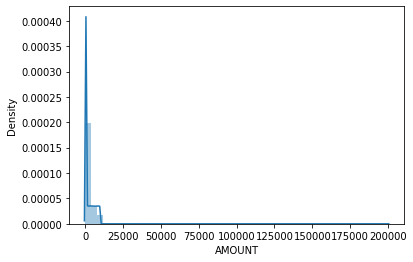

In [4]:
amount_plot = sns.distplot(ftxn2_df['AMOUNT'], bins=50)
amount_fig = amount_plot.get_figure()
amount_fig.savefig("./plots/amount_density.png")

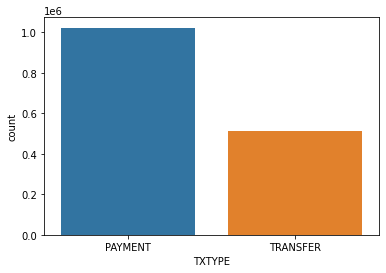

In [5]:
txn_type_plot = sns.countplot('TXTYPE', data=ftxn2_df)
txn_type_fig = txn_type_plot.get_figure()
txn_type_fig.savefig("./plots/txn_type_density.png")

In [11]:
print(faccount_df.columns)
print(ftxn2_df.columns)

Index(['ACCTID', 'ACCTTYPE', 'ACCTNAME', 'FIRSTNAME', 'SURNAME', 'DOB',
       'ACCTCREATED', 'ACCTRISK', 'ADDRESS', 'ADDRESS_LAT', 'ADDRESS_LON',
       'CATEGORY'],
      dtype='object')
Index(['TXN_ID', 'TXTYPE', 'AMOUNT', 'FROMACCTID', 'TOACCTID', 'TXDATE',
       'REFERENCE', 'ISFRAUD', 'ISFLAGGED'],
      dtype='object')


In [6]:
#account types
print(faccount_df["ACCTTYPE"].unique())

#account categories
print(faccount_df["CATEGORY"].unique())


['BUSINESS' 'CREDIT' 'MAXI-SAVER' 'SAVINGS']
['Supermarket' 'Grocery' 'Cafe' 'Bakery' 'Hotel' 'Restaurant' 'Builders'
 'Lawyers' 'Crash Repairs' 'Apparel' 'Smallgoods' 'Property' 'Cleaning'
 'Gardening' 'Electrical' 'Wholesale' 'Events' 'Computers' 'Clinic'
 'Winery' 'Roasters' 'Pottery' 'Therapeutics' 'Fitness' 'Physiotherapy'
 'Beauty' 'Podiatry' 'Florist' 'Finance' 'Sports' 'Brewery' 'Used Cars'
 'Garage' 'Pharmacy' 'Butcher' 'Consulting' 'Distillery' 'Cheeses'
 'Management' 'Services' 'Childcare' 'Digital' 'Accounting' 'Salamis'
 'Trading' 'Music' 'CUSTOMER']


In [7]:
faccount_engineered = pd.DataFrame([])

faccount_engineered['ACCTID'] = faccount_df['ACCTID']

#add the person's full name 
faccount_engineered['FULLNAME'] = faccount_df['FIRSTNAME']+" "+faccount_df['SURNAME']

#add account type id, id generated by the order of unique accttypes
accttype = faccount_df["ACCTTYPE"].unique()
categorytype = faccount_df["CATEGORY"].unique()

def return_id(dataframe, array_to_search):
   return np.where(dataframe==array_to_search)

faccount_engineered['ACCTTYPE'] = faccount_df["ACCTTYPE"].astype('category').cat.codes

faccount_engineered['CATEGORY'] = faccount_df["CATEGORY"].astype('category').cat.codes


#count the number of time a person created an account
faccount_engineered['same_person_count'] = faccount_engineered.groupby('FULLNAME')['FULLNAME'].transform('count')

faccount_engineered[faccount_engineered['ACCTID']==800242].head()


,ACCTID,FULLNAME,ACCTTYPE,CATEGORY,same_person_count
280,800242,Taylor Marshall,1,35,1


In [21]:
from datetime import datetime
from datetime import datetime, timedelta


joined_features = ftxn2_df.merge(faccount_engineered, left_on='FROMACCTID', right_on='ACCTID')

#convert datetime string to datetime onj
joined_features['TXDATE'] = pd.to_datetime(joined_features['TXDATE'], format='%Y-%m-%d %H:%M:%S')

joined_features = joined_features.drop(columns=['ISFRAUD', 'ISFLAGGED', 'ACCTID', 'FULLNAME'])

joined_features = joined_features.rename(columns={'ACCTTYPE':'ACCTTYPEFROM', 'CATEGORY':'CATEGORYFROM'})

joined_features = joined_features.merge(faccount_engineered, left_on='TOACCTID', right_on='ACCTID')

joined_features = joined_features.drop(columns=['ACCTID', 'FULLNAME'])

joined_features = joined_features.rename(columns={'ACCTTYPE':'ACCTTYPETO', 'CATEGORY':'CATEGORYTO'})

#changing transation type to categorical labels
joined_features['TXTYPE'] = joined_features["TXTYPE"].astype('category').cat.codes

joined_features = joined_features.drop(columns=['TXN_ID', 'REFERENCE'])


#sort by date
joined_features = joined_features.sort_values(by=['TXDATE']).set_index('TXDATE')

#get the last 5 day sum transfered from each account and the number of transactions each account performed
joined_features['sum_5days'] = joined_features.groupby('FROMACCTID')['AMOUNT'].transform(lambda s: s.rolling(timedelta(days=5)).sum())

joined_features['count_5days'] = joined_features.groupby('FROMACCTID')['AMOUNT'].transform(lambda s: s.rolling(timedelta(days=5)).count())



joined_features.head()

,TXTYPE,AMOUNT,FROMACCTID,TOACCTID,ACCTTYPEFROM,CATEGORYFROM,same_person_count_x,ACCTTYPETO,CATEGORYTO,same_person_count_y,sum_5days,count_5days
TXDATE,,,,,,,,,,,,
2019-10-02 08:00:00,0,29,501260,800125,3,7,2,0,2,1,29,1
2019-10-02 08:00:00,0,76,500304,800110,3,7,1,0,8,1,76,1
2019-10-02 08:00:00,0,71,500700,800120,3,7,1,0,2,1,71,1
2019-10-02 08:00:00,0,39,501098,800137,3,7,1,0,2,1,39,1
2019-10-02 08:00:00,0,79,501258,800149,2,7,1,0,8,1,79,1


In [39]:
# from sklearn import preprocessing

# min_max_scaler = preprocessing.MinMaxScaler()

# timestamp_vals = joined_features['timestamp'].values.reshape(-1,1)
# timestamp_scaled = min_max_scaler.fit_transform(timestamp_vals)
# joined_features['timestamp_normed'] = timestamp_scaled[:,0]


# final_joined_features = joined_features

# final_joined_features = final_joined_features.drop(columns=['timestamp'])
# final_joined_features.head(10)



In [23]:
joined_features = joined_features.drop(columns=['FROMACCTID', 'TOACCTID'])

joined_features.to_csv('./dataset/joined_features.txt', index=False)